# Zero-Shot and Few-Shot Classification

In this notebook, we explore how **pretrained transformers** (like BERT, RoBERTa, and DeBERTa) can be used for **classification tasks** — with **little to no labeled data**.

We'll apply multiple strategies to the **IMDB sentiment dataset**, going from fully zero-shot to very low-shot learning.

---

## Introduction to the task

### 🧭 What You’ll Learn

- How to classify texts **without labeled examples** using pretrained language models.
- The difference between **semantic similarity**, **inference-based classification**, and **language modeling-based prompts**.
- How to simulate labeling with **weak supervision** and use those labels to train models.
- How **SetFit** enables efficient few-shot learning with great results and low compute.

---

### 📚 Methods We’ll Explore

| Method                        | Style                        | Supervision  | Based On           |
|------------------------------|------------------------------|--------------|--------------------|
| 1️⃣ Latent Embedding Matching | Cosine similarity of vectors | ❌ None       | Sentence Transformers |
| 2️⃣ NLI-based Inference        | Premise + Hypothesis         | ❌ None       | BERT for NLI       |
| 3️⃣ Cloze Task Prompting       | Fill-in-the-blank format     | ❌ None       | Masked LM (BERT)   |
| 4️⃣ Weak Supervision (Snorkel) | Heuristic labeling           | ⚠️ Partial    | Rules / Functions  |
| 5️⃣ SetFit                    | Contrastive + classifier     | ✅ 4–128 docs | Sentence-BERT      |

---

### 🧪 Dataset: IMDB Sentiment

We'll use the [IMDB dataset](https://huggingface.co/datasets/imdb), a binary sentiment classification task:
- **Positive reviews** → label 1
- **Negative reviews** → label 0

---

### 📌 Notebook Structure

1. **Load the IMDB dataset**
2. 🔍 Zero-shot classification:
   - Sentence embedding similarity
   - Natural language inference
   - Cloze prompting
3. ⚙️ Weak supervision with Snorkel
4. 🚀 Few-shot learning with SetFit (4 → 128 examples)
5. 📈 Compare performance across strategies

Let’s get started by loading and preparing the dataset.

---

## 📥 Step 1: Load and Preprocess the IMDB Dataset

We'll use the `datasets` library from Hugging Face to load the **IMDB sentiment dataset**, which contains:
- 25,000 training reviews
- 25,000 test reviews
- Binary labels:  
  - `1` → Positive  
  - `0` → Negative

We'll also sample subsets for quicker prototyping, and later use larger slices for methods like SetFit.

For consistency, we’ll rename `label` to `labels`, and lowercase the text.

In [3]:
from datasets import load_dataset, DatasetDict
import pandas as pd

# Load IMDB dataset (train/test)
raw = load_dataset("imdb")
dataset = DatasetDict({
    "train": raw["train"],
    "test": raw["test"]
})

# Convert to lowercase for consistency
dataset = dataset.map(lambda x: {"text": [t.lower() for t in x["text"]]}, batched=True)

# Rename label column for compatibility
dataset = dataset.rename_column("label", "labels")

# Show a small sample
for i in dataset["train"].shuffle(seed=42).select(range(3)):
    print(i["text"])
    print(i["labels"])
    print("-"*100)

there is no relation at all between fortier and profiler but the fact that both are police series about violent crimes. profiler looks crispy, fortier looks classic. profiler plots are quite simple. fortier's plot are far more complicated... fortier looks more like prime suspect, if we have to spot similarities... the main character is weak and weirdo, but have "clairvoyance". people like to compare, to judge, to evaluate. how about just enjoying? funny thing too, people writing fortier looks american but, on the other hand, arguing they prefer american series (!!!). maybe it's the language, or the spirit, but i think this series is more english than american. by the way, the actors are really good and funny. the acting is not superficial at all...
1
----------------------------------------------------------------------------------------------------
this movie is a great. the plot is very true to the book which is a classic written by mark twain. the movie starts of with a scene where 

## 🧠 Step 2: Zero-Shot Classification via Latent Embedding Matching

This method uses **semantic similarity** between a review and class descriptions — without needing any labeled training data.

### ✅ How It Works (via Hugging Face Pipelines):
1. We use a pretrained language model to encode both the **input sentence** and **candidate class labels** (e.g., `"positive"` and `"negative"`).
2. The model frames this as an **entailment task**:
   - “Does this sentence entail that the label applies?”
3. It returns a **confidence score** for each label.
4. The label with the highest score is chosen as the prediction.

This is implemented with Hugging Face’s `zero-shot-classification` pipeline under the hood — which uses **Natural Language Inference (NLI)** as the mechanism.

---

### 🔍 Models Compared:
We’ll evaluate performance across three different transformer backbones:

| Model        | Description                                 |
|--------------|---------------------------------------------|
| `bert-base-uncased`   | Google’s original BERT                |
| `roberta-base`        | Facebook AI’s optimized BERT variant |
| `distilbert-base-uncased` | Smaller, faster distilled BERT     |

Each model handles the inference task slightly differently depending on its pretraining, so we’ll print out predicted labels, true labels, and label probabilities to compare.

Next: we’ll scale this approach to the entire test set and evaluate precision, recall, and F1!

In [15]:
from transformers import pipeline
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report

# Define candidate labels
labels = ["positive", "negative"]

examples = dataset["train"].shuffle(seed=42).select(range(3))

models = {
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DistilBERT": "distilbert-base-uncased"
}

for model_name, model_path in models.items():
    print(f"Loading zero-shot classification pipeline for {model_name}...")
    # Load zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model=model_path)

    for example in examples:
        result = classifier(example["text"], labels)
        print(f"\n📄 Review: {example['text'][:100]}...")
        print(f"🔍 Predicted: {result['labels'][0]}, True: {labels[example['labels']]}")
        print(f"📊 Probabilities: {[f'{p:.4f}' for p in result['scores']]}")
        print("-"*100)

Loading zero-shot classification pipeline for BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.



📄 Review: there is no relation at all between fortier and profiler but the fact that both are police series ab...
🔍 Predicted: negative, True: negative
📊 Probabilities: ['0.5090', '0.4910']
----------------------------------------------------------------------------------------------------

📄 Review: this movie is a great. the plot is very true to the book which is a classic written by mark twain. t...
🔍 Predicted: negative, True: negative
📊 Probabilities: ['0.5562', '0.4438']
----------------------------------------------------------------------------------------------------

📄 Review: george p. cosmatos' "rambo: first blood part ii" is pure wish-fulfillment. the united states clearly...
🔍 Predicted: positive, True: positive
📊 Probabilities: ['0.5007', '0.4993']
----------------------------------------------------------------------------------------------------
Loading zero-shot classification pipeline for RoBERTa...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.



📄 Review: there is no relation at all between fortier and profiler but the fact that both are police series ab...
🔍 Predicted: negative, True: negative
📊 Probabilities: ['0.5002', '0.4998']
----------------------------------------------------------------------------------------------------

📄 Review: this movie is a great. the plot is very true to the book which is a classic written by mark twain. t...
🔍 Predicted: negative, True: negative
📊 Probabilities: ['0.5002', '0.4998']
----------------------------------------------------------------------------------------------------

📄 Review: george p. cosmatos' "rambo: first blood part ii" is pure wish-fulfillment. the united states clearly...
🔍 Predicted: negative, True: positive
📊 Probabilities: ['0.5001', '0.4999']
----------------------------------------------------------------------------------------------------
Loading zero-shot classification pipeline for DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.



📄 Review: there is no relation at all between fortier and profiler but the fact that both are police series ab...
🔍 Predicted: positive, True: negative
📊 Probabilities: ['0.5007', '0.4993']
----------------------------------------------------------------------------------------------------

📄 Review: this movie is a great. the plot is very true to the book which is a classic written by mark twain. t...
🔍 Predicted: negative, True: negative
📊 Probabilities: ['0.5002', '0.4998']
----------------------------------------------------------------------------------------------------

📄 Review: george p. cosmatos' "rambo: first blood part ii" is pure wish-fulfillment. the united states clearly...
🔍 Predicted: positive, True: positive
📊 Probabilities: ['0.5009', '0.4991']
----------------------------------------------------------------------------------------------------


Now that we’ve tested a few examples, it’s time to **scale up** and evaluate how well these models perform on a real sample of the dataset.

---

### ⚙️ What We're Doing:

- We take a **random sample** of 500 IMDB reviews from the test set.
- For each review, we use the `zero-shot-classification` pipeline to decide whether it's `"positive"` or `"negative"`.
- We do this for **three models**:
  - `bert-base-uncased`
  - `roberta-base`
  - `distilbert-base-uncased`

---

### 📊 Evaluation Metrics:

After classifying, we calculate:
- **Precision**: What proportion of predicted positives are actually positive?
- **Recall**: What proportion of actual positives did we catch?
- **F1 Score**: Harmonic mean of precision and recall — a balance between them.
- **Accuracy**: Total percentage of correct predictions.

We also:
- **Print a few review examples** with their predicted label and model confidence.
- **Compare the overall accuracy** of all three models side by side.

---

### 📌 Note on Probabilities:

We extract the model’s raw **label probabilities**, and normalize them to ensure they sum to 1 for each prediction:
```python
probs.append([positive_score, 1 - positive_score])


In [16]:
from transformers import pipeline
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report

# Get test data
test_texts = dataset["test"]["text"]
true_labels = dataset["test"]["labels"]

# Sample a subset for faster processing
sample_size = 500
random_indices = np.random.choice(len(test_texts), size=sample_size, replace=False)
sample_texts = [test_texts[i] for i in random_indices]
sample_labels = [true_labels[i] for i in random_indices]

# Define candidate labels
labels = ["positive", "negative"]

# Dictionary to store results for comparison
all_results = {}

# Define models to test
model_names = ["bert-base-uncased", "roberta-base", "distilbert-base-uncased"]

# Process with each model
for model_name in model_names:
    print(f"\n🔍 Evaluating {model_name} Zero-Shot Classification")
    
    # Load zero-shot classification pipeline with specific model
    classifier = pipeline("zero-shot-classification", model=model_name)
    
    # Process examples in batches to avoid memory issues
    batch_size = 8
    preds = []
    probs = []
    
    for i in tqdm(range(0, len(sample_texts), batch_size), desc=f"Classifying with {model_name}"):
        batch_texts = sample_texts[i:i+batch_size]
        batch_results = classifier(batch_texts, labels, multi_label=False)
        
        # Handle single result vs batch results
        if not isinstance(batch_results, list):
            batch_results = [batch_results]
            
        for result in batch_results:
            # Get scores
            scores = result['scores']
            # Get index of positive label
            pos_idx = result['labels'].index('positive')
            # Store probability of positive class
            probs.append([scores[pos_idx], 1-scores[pos_idx]])
            # Predict label (1 for positive, 0 for negative)
            pred = 1 if scores[pos_idx] > 0.5 else 0
            preds.append(pred)
    
    # Evaluate
    report = classification_report(sample_labels, preds, target_names=labels, output_dict=True)
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(sample_labels, preds, target_names=labels))
    
    # Store results for comparison
    all_results[model_name] = {
        "predictions": preds,
        "probabilities": np.array(probs),
        "report": report
    }
    
    # Print a few examples
    num_examples = 3
    for i in range(num_examples):
        print(f"\n📄 Review: {sample_texts[i][:100]}...")
        print(f"🔍 Predicted: {labels[preds[i]]}, True: {labels[sample_labels[i]]}")
        print(f"📊 Probabilities: {[f'{p:.4f}' for p in probs[i]]}")

# Compare model performance
print("\n📊 Model Comparison (Accuracy):")
for model_name in model_names:
    acc = all_results[model_name]["report"]["accuracy"]
    print(f"{model_name}: {acc:.4f}")


🔍 Evaluating bert-base-uncased Zero-Shot Classification


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Classifying with bert-base-uncased: 100%|██████████| 63/63 [01:43<00:00,  1.64s/it]


Classification Report for bert-base-uncased:

              precision    recall  f1-score   support

    positive       0.62      0.58      0.60       238
    negative       0.64      0.68      0.66       262

    accuracy                           0.63       500
   macro avg       0.63      0.63      0.63       500
weighted avg       0.63      0.63      0.63       500


📄 Review: (a possible minor spoiler) the first "jurassic park" was an effective, but silly film that did it's ...
🔍 Predicted: negative, True: positive
📊 Probabilities: ['0.5117', '0.4883']

📄 Review: i just saw this film at the sidewalk film festival in birmingham, al, which was actually a really fu...
🔍 Predicted: positive, True: negative
📊 Probabilities: ['0.4918', '0.5082']

📄 Review: stay away from this movie at all costs. i was suckered into watching this movie in a bet to see whic...
🔍 Predicted: positive, True: positive
📊 Probabilities: ['0.4832', '0.5168']

🔍 Evaluating roberta-base Zero-Shot Classification


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Classifying with roberta-base: 100%|██████████| 63/63 [02:17<00:00,  2.19s/it]


Classification Report for roberta-base:

              precision    recall  f1-score   support

    positive       0.50      0.89      0.64       238
    negative       0.66      0.20      0.31       262

    accuracy                           0.53       500
   macro avg       0.58      0.54      0.48       500
weighted avg       0.59      0.53      0.47       500


📄 Review: (a possible minor spoiler) the first "jurassic park" was an effective, but silly film that did it's ...
🔍 Predicted: positive, True: positive
📊 Probabilities: ['0.5000', '0.5000']

📄 Review: i just saw this film at the sidewalk film festival in birmingham, al, which was actually a really fu...
🔍 Predicted: negative, True: negative
📊 Probabilities: ['0.5000', '0.5000']

📄 Review: stay away from this movie at all costs. i was suckered into watching this movie in a bet to see whic...
🔍 Predicted: positive, True: positive
📊 Probabilities: ['0.5000', '0.5000']

🔍 Evaluating distilbert-base-uncased Zero-Shot Classificat

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Classifying with distilbert-base-uncased: 100%|██████████| 63/63 [00:38<00:00,  1.65it/s]

Classification Report for distilbert-base-uncased:

              precision    recall  f1-score   support

    positive       0.45      0.02      0.04       238
    negative       0.52      0.98      0.68       262

    accuracy                           0.52       500
   macro avg       0.49      0.50      0.36       500
weighted avg       0.49      0.52      0.38       500


📄 Review: (a possible minor spoiler) the first "jurassic park" was an effective, but silly film that did it's ...
🔍 Predicted: negative, True: positive
📊 Probabilities: ['0.5013', '0.4987']

📄 Review: i just saw this film at the sidewalk film festival in birmingham, al, which was actually a really fu...
🔍 Predicted: negative, True: negative
📊 Probabilities: ['0.5015', '0.4985']

📄 Review: stay away from this movie at all costs. i was suckered into watching this movie in a bet to see whic...
🔍 Predicted: negative, True: positive
📊 Probabilities: ['0.5024', '0.4976']

📊 Model Comparison (Accuracy):
bert-base-uncase

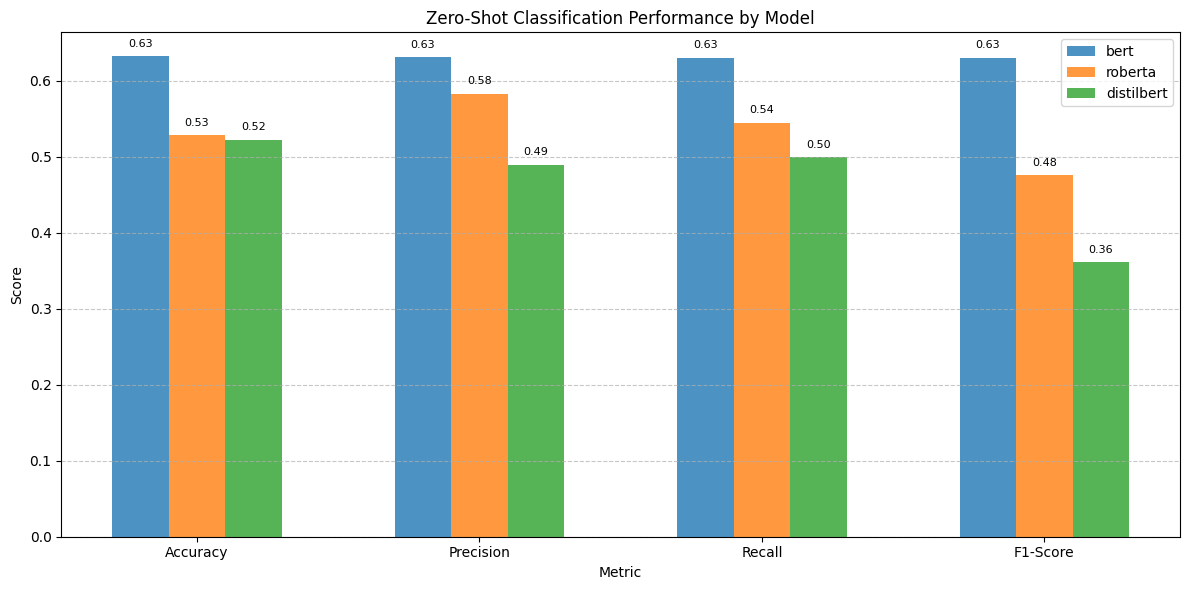

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract metrics for comparison
metrics_data = []

for model_name in model_names:
    report = all_results[model_name]["report"]
    
    # Get overall metrics
    accuracy = report["accuracy"]
    
    # Get averaged metrics (macro avg)
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]
    
    # Store in data list
    metrics_data.append({
        "Model": model_name.split("-")[0],  # Just use first part of model name
        "Accuracy": accuracy,
        "Precision": macro_precision,
        "Recall": macro_recall,
        "F1-Score": macro_f1
    })

# Convert to DataFrame
df = pd.DataFrame(metrics_data)

# Reshape for grouped bar chart
metrics_df = pd.melt(df, 
                     id_vars=["Model"],
                     value_vars=["Accuracy", "Precision", "Recall", "F1-Score"],
                     var_name="Metric", value_name="Score")

# Set up the plot
plt.figure(figsize=(12, 6))
bar_width = 0.2
opacity = 0.8

# Create grouped bar chart
ax = plt.subplot(111)

# Get unique models and metrics
models = df["Model"].unique()
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Set x positions for bars
x_pos = np.arange(len(metrics))

# Plot bars for each model
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df["Model"] == model]
    offset = bar_width * (i - len(models)/2 + 0.5)
    plt.bar(x_pos + offset, 
            model_data["Score"], 
            bar_width, 
            alpha=opacity,
            label=model)

# Customize plot
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Zero-Shot Classification Performance by Model')
plt.xticks(x_pos, metrics)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add value labels on top of bars
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df["Model"] == model]
    offset = bar_width * (i - len(models)/2 + 0.5)
    
    for j, score in enumerate(model_data["Score"]):
        plt.text(j + offset, score + 0.01, f'{score:.2f}', 
                 ha='center', va='bottom', fontsize=8)

plt.show()

Let’s break down how our **zero-shot classification models** performed on the IMDB test data — and compare them to a simple **TF-IDF + Logistic Regression** baseline from earlier sessions (which achieved **~88% accuracy, precision, and recall**).

---

### 🧪 Observations by Model:

#### ✅ `bert-base-uncased`:
- **Best performer** among the three transformers.
- Achieved **63% accuracy**, with balanced **precision/recall** around 62–64%.
- Shows that **semantic similarity in embedding space** is informative — but not yet optimal.
- Useful when no labeled data is available, but still far behind supervised approaches.

#### ⚠️ `roberta-base`:
- Very **high recall for “positive”** (89%) but **terrible recall for “negative”** (20%).
- Imbalanced predictions — likely overpredicting "positive".
- Accuracy drops to **53%**, meaning **essentially random performance**.
- May stem from how RoBERTa handles label semantics without fine-tuning.

#### 🚨 `distilbert-base-uncased`:
- Nearly always predicts **“negative”**: 98% recall for negative, but **only 2% recall for positive**.
- Accuracy again **~52%**, but for the wrong reasons.
- This suggests **severe bias or label interpretation mismatch** in this zero-shot setting.

---

### 🧠 Key Takeaways:

- **Zero-shot classification is appealing** — but has limits, especially in binary sentiment classification where:
  - Labels like `"positive"` and `"negative"` are highly **subjective**.
  - The model may have different semantic priors (e.g., "positive" meaning *good*, but not *positive review*).
- Performance **lags far behind traditional supervised methods** like Logistic Regression with TF-IDF, which hit **~88%** on all metrics.
- Still, **BERT's moderate success** shows the potential of using **pretrained language models** without labeled data — particularly in **low-resource** or **rapid prototyping** scenarios.

---

## 🧠 Step 3: Zero-Shot Classification via Natural Language Inference (NLI)

Now let’s reframe the problem of sentiment classification as an **inference task**.

### 🧬 What is NLI?

**Natural Language Inference (NLI)** involves determining the logical relationship between two sentences:
- **Premise**: a factual or observed sentence (our input text).
- **Hypothesis**: a candidate statement we want to test (e.g., "This is a positive review").

The model must decide whether the hypothesis:
- **Entails** the premise (true)
- **Contradicts** the premise (false)
- Is **neutral** (undetermined)

---

### 🧪 How We Use It for Classification:

We use a **specialized NLI model** (like `facebook/bart-large-mnli`) that has been trained on large NLI datasets.

#### For each review:
1. Treat the **review** as the *premise*.
2. Create two *hypotheses*:
   - `"This is a positive review."`
   - `"This is a negative review."`
3. The model scores each hypothesis for **entailment probability**.
4. We normalize the scores and pick the class with the highest entailment.

---

### 🤖 NLI Models to Try:
- `facebook/bart-large-mnli` – One of the most reliable NLI-capable models.
- `roberta-large-mnli` – RoBERTa variant fine-tuned on MultiNLI dataset.

Let’s now run this method across the IMDB test set and compare performance to our previous zero-shot embedding-based approach.

In [ ]:
from transformers import pipeline
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Define candidate labels and the hypotheses
labels = ["positive", "negative"]
hypothesis_template = "This is a {} review."

# Dictionary to store results for comparison
nli_results = {}

# Define NLI models to test
nli_model_names = ["facebook/bart-large-mnli", "roberta-large-mnli"]

# Process with each NLI model
for model_name in nli_model_names:
    print(f"\n🔍 Evaluating {model_name} Zero-Shot NLI Classification")
    
    # Load zero-shot classification pipeline with specific model
    # Use NLI model to perform zero-shot classification
    classifier = pipeline("zero-shot-classification", model=model_name)
    
    # Process examples in batches to avoid memory issues
    batch_size = 8
    preds = []
    probs = []
    
    for i in tqdm(range(0, len(sample_texts), batch_size), desc=f"Classifying with {model_name}"):
        batch_texts = sample_texts[i:i+batch_size]
        # Use hypothesis template
        batch_results = classifier(
            batch_texts, 
            labels, 
            hypothesis_template=hypothesis_template,
            multi_label=False
        )
        
        # Handle single result vs batch results
        if not isinstance(batch_results, list):
            batch_results = [batch_results]
            
        for result in batch_results:
            # Get scores
            scores = result['scores']
            # Get index of positive label
            pos_idx = result['labels'].index('positive')
            # Store probability of positive class
            probs.append([scores[pos_idx], 1-scores[pos_idx]])
            # Predict label (1 for positive, 0 for negative)
            pred = 1 if scores[pos_idx] > 0.5 else 0
            preds.append(pred)
    
    # Evaluate
    report = classification_report(sample_labels, preds, target_names=labels, output_dict=True)
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(sample_labels, preds, target_names=labels))
    
    # Store results for comparison
    nli_results[model_name] = {
        "predictions": preds,
        "probabilities": np.array(probs),
        "report": report
    }
    
    # Print a few examples
    num_examples = 3
    for i in range(num_examples):
        print(f"\n📄 Review: {sample_texts[i][:100]}...")
        print(f"🔍 Predicted: {labels[preds[i]]}, True: {labels[sample_labels[i]]}")
        print(f"📊 Probabilities: {[f'{p:.4f}' for p in probs[i]]}")

# Combine all results for comparison
combined_results = {}
combined_results.update(all_results)  # Previous models
combined_results.update(nli_results)  # NLI models

# Extract metrics for comparison
metrics_data = []

for model_name, result in combined_results.items():
    # Get model short name
    if "/" in model_name:
        model_short = model_name.split("/")[1]
    else:
        model_short = model_name
        
    report = result["report"]
    
    # Get overall metrics
    accuracy = report["accuracy"]
    
    # Get averaged metrics (macro avg)
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]
    
    # Store in data list
    metrics_data.append({
        "Model": model_short,
        "Accuracy": accuracy,
        "Precision": macro_precision,
        "Recall": macro_recall,
        "F1-Score": macro_f1
    })



🔍 Evaluating facebook/bart-large-mnli Zero-Shot NLI Classification


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use mps:0
Classifying with facebook/bart-large-mnli: 100%|██████████| 63/63 [07:51<00:00,  7.49s/it]


Classification Report for facebook/bart-large-mnli:

              precision    recall  f1-score   support

    positive       0.92      0.92      0.92       238
    negative       0.93      0.92      0.93       262

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500


📄 Review: (a possible minor spoiler) the first "jurassic park" was an effective, but silly film that did it's ...
🔍 Predicted: positive, True: positive
📊 Probabilities: ['0.0570', '0.9430']

📄 Review: i just saw this film at the sidewalk film festival in birmingham, al, which was actually a really fu...
🔍 Predicted: negative, True: negative
📊 Probabilities: ['0.9445', '0.0555']

📄 Review: stay away from this movie at all costs. i was suckered into watching this movie in a bet to see whic...
🔍 Predicted: positive, True: positive
📊 Probabilities: ['0.0072', '0.9928']

🔍 Evaluating roberta-large-mnli Zero-Shot NLI 

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use mps:0
Classifying with roberta-large-mnli: 100%|██████████| 63/63 [06:03<00:00,  5.78s/it]

Classification Report for roberta-large-mnli:

              precision    recall  f1-score   support

    positive       0.82      0.88      0.85       238
    negative       0.88      0.82      0.85       262

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500


📄 Review: (a possible minor spoiler) the first "jurassic park" was an effective, but silly film that did it's ...
🔍 Predicted: positive, True: positive
📊 Probabilities: ['0.2776', '0.7224']

📄 Review: i just saw this film at the sidewalk film festival in birmingham, al, which was actually a really fu...
🔍 Predicted: negative, True: negative
📊 Probabilities: ['0.9864', '0.0136']

📄 Review: stay away from this movie at all costs. i was suckered into watching this movie in a bet to see whic...
🔍 Predicted: positive, True: positive
📊 Probabilities: ['0.0052', '0.9948']


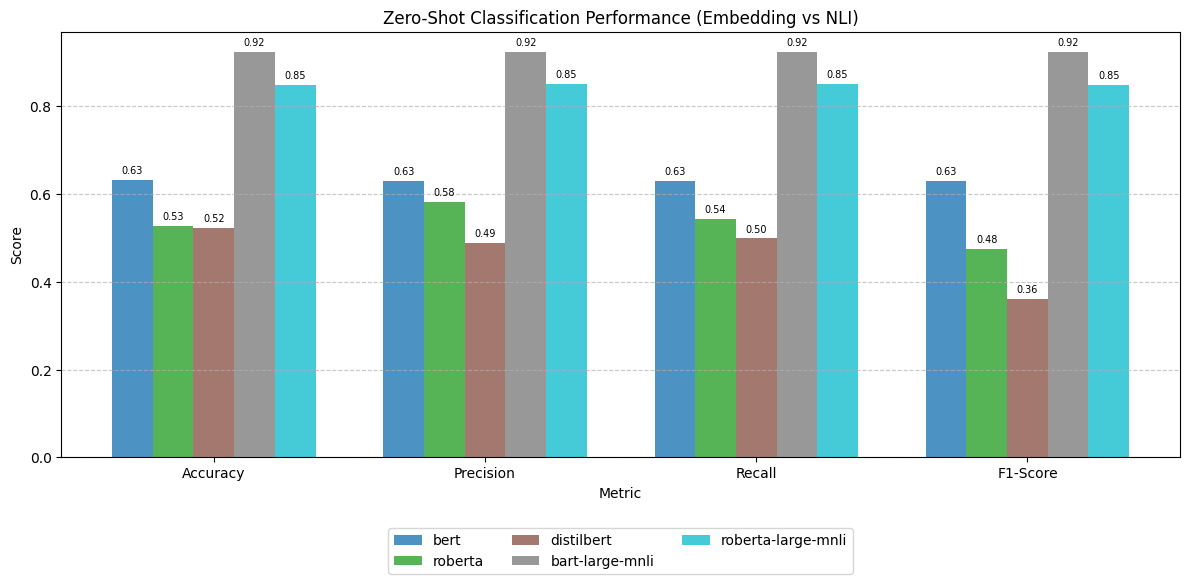


📊 Model Comparison (Accuracy):
bart-large-mnli: 0.9240
roberta-large-mnli: 0.8500
bert-base-uncased: 0.6320
roberta-base: 0.5280
distilbert-base-uncased: 0.5220


In [26]:
# Convert to DataFrame
df = pd.DataFrame(metrics_data)

# Reshape for grouped bar chart
metrics_df = pd.melt(df, 
                     id_vars=["Model"],
                     value_vars=["Accuracy", "Precision", "Recall", "F1-Score"],
                     var_name="Metric", value_name="Score")

# Set up the plot
plt.figure(figsize=(12, 6))
bar_width = 0.15
opacity = 0.8

# Create grouped bar chart
ax = plt.subplot(111)

# Get unique models and metrics
models = df["Model"].unique()
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Set x positions for bars
x_pos = np.arange(len(metrics))

# Plot bars for each model
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df["Model"] == model]
    
    # Make sure we have all metrics for this model
    values = []
    for metric in metrics:
        metric_row = model_data[model_data["Metric"] == metric]
        if len(metric_row) > 0:
            values.append(metric_row["Score"].values[0])
        else:
            values.append(0)  # Default if missing
    
    offset = bar_width * (i - len(models)/2 + 0.5)
    plt.bar(x_pos + offset, 
            values, 
            bar_width, 
            alpha=opacity,
            color=colors[i],
            label=model)

# Customize plot
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Zero-Shot Classification Performance (Embedding vs NLI)')
plt.xticks(x_pos, metrics)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add value labels on top of bars
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df["Model"] == model]
    offset = bar_width * (i - len(models)/2 + 0.5)
    
    values = []
    for metric in metrics:
        metric_row = model_data[model_data["Metric"] == metric]
        if len(metric_row) > 0:
            values.append(metric_row["Score"].values[0])
        else:
            values.append(0)
    
    for j, score in enumerate(values):
        plt.text(j + offset, score + 0.01, f'{score:.2f}', 
                 ha='center', va='bottom', fontsize=7)


plt.show()

# Print comparative summary
print("\n📊 Model Comparison (Accuracy):")
for model_name, result in sorted(combined_results.items(), key=lambda x: x[1]["report"]["accuracy"], reverse=True):
    acc = result["report"]["accuracy"]
    if "/" in model_name:
        model_short = model_name.split("/")[1]
    else:
        model_short = model_name
    print(f"{model_short}: {acc:.4f}")

Let’s take a look at how well the NLI-based zero-shot models performed on IMDB sentiment classification:

### 🔍 Performance Summary:

| Model                    | Accuracy | Precision | Recall | F1 Score |
|--------------------------|----------|-----------|--------|----------|
| **`facebook/bart-large-mnli`** | **92%**      | 0.92/0.93 | 0.92    | **0.93**    |
| **`roberta-large-mnli`**       | 85%      | 0.82/0.88 | 0.88    | 0.85    |
| **TF-IDF + Logistic Regression** | 88%  | 0.88      | 0.88    | 0.88    |

---

### 🤯 Why is `bart-large-mnli` so strong?

These models were **explicitly fine-tuned for NLI tasks** like entailment and contradiction detection using datasets like **MultiNLI**, which contain thousands of sentence pairs with reasoning-based annotations.

That makes them naturally good at:
- Understanding nuanced semantic relationships.
- Inferring sentiment or intent when framed as *"This is a positive/negative review."*

So even though we **never trained them on sentiment labels**, they generalize remarkably well to this task through **semantic reasoning**.

---

### 🧠 Takeaway: Choose Models Aligned With Your Task

The results here highlight a key lesson:

> ✅ **Before building or fine-tuning anything, check the Hugging Face Hub!**

There may already be:
- Models trained on **tasks similar to yours** (e.g., NLI, sentiment, question answering).
- Tools like `zero-shot-classification` pipelines that make deployment easy.

Using such models can help in:
- Bootstrapping pseudo-labels (for weak supervision).
- Rapid prototyping and feasibility testing.
- Avoiding unnecessary fine-tuning when generalization is strong.

---

## 🧩 Step 4: Zero-Shot Classification as Cloze Tasks (Masked Language Modeling)

In this approach, we **reformulate classification as a fill-in-the-blank problem**, using models like BERT that are trained to predict masked tokens.

---

### 📖 What is a Cloze Task?

Originally used in language learning, a **cloze task** asks a model to fill in a missing word in a sentence:

> "This movie was [MASK]."

Pretrained masked language models (like **BERT**) can predict the most probable word(s) for the `[MASK]`. If we craft our prompt carefully, the prediction can directly indicate the class label.

---

### 🧠 Example: Sentiment Classification

We can convert the input review into a prompt like:

> "The review said: *'The story was thrilling and well-acted.'* Overall, it was [MASK]."

If BERT predicts `"great"` or `"good"` → positive  
If it predicts `"bad"` or `"boring"` → negative  

We define a small **vocabulary of candidate labels** to constrain the model's output and interpret the results as a classification.

---

### 🧪 Reference: Schick & Schütze (2020)

This idea is inspired by the paper [**"Exploiting Cloze Questions for Few-Shot Text Classification and Natural Language Inference"**](https://arxiv.org/abs/2001.07676), where the authors:

- Reformulate **classification as cloze questions**, asking the model to predict the label directly within a sentence.
- Propose using **multiple prompt templates** to reduce bias and improve robustness.
- Show that **pretrained MLMs (like BERT)** can perform few-shot learning effectively using only prompts + label words, without gradient updates.

In [36]:
examples = dataset["train"].shuffle(seed=42).select(range(3))

models = {
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DistilBERT": "distilbert-base-uncased"
}

#cloze_task = f"The review said: *'my_review_here'* Overall, it was [MASK]."

for model_name, model_path in models.items():
    print(f"Loading fill-mask pipeline for {model_name}...")
    # Load fill-mask pipeline
    classifier = pipeline("fill-mask", model=model_path)
    
    # Define mask token based on model
    mask_token = "<mask>" if "roberta" in model_path else "[MASK]"
    
    for example in examples:
        # Create masked input with sentiment at the end
        masked_text = f"The review said: *'{example['text']}'* Overall, it was {mask_token}."
        result = classifier(masked_text)
        print(f"\n📄 Review: {example['text'][:100]}...")
        
        # Fix the f-string syntax
        top_predictions = [r["token_str"] for r in result[:5]]
        top_scores = [f"{r['score']:.4f}" for r in result[:5]]
        
        print(f"🔍 Top predictions: {top_predictions}")
        print(f"📊 Probabilities: {top_scores}")
        print("-"*100)

Loading fill-mask pipeline for BERT...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0



📄 Review: there is no relation at all between fortier and profiler but the fact that both are police series ab...
🔍 Top predictions: ['good', 'great', 'average', 'positive', 'fantastic']
📊 Probabilities: ['0.1738', '0.1232', '0.0386', '0.0358', '0.0331']
----------------------------------------------------------------------------------------------------

📄 Review: this movie is a great. the plot is very true to the book which is a classic written by mark twain. t...
🔍 Top predictions: ['great', 'good', 'fantastic', 'amazing', 'enjoyable']
📊 Probabilities: ['0.1982', '0.1675', '0.0857', '0.0505', '0.0326']
----------------------------------------------------------------------------------------------------

📄 Review: george p. cosmatos' "rambo: first blood part ii" is pure wish-fulfillment. the united states clearly...
🔍 Top predictions: ['good', 'interesting', 'great', 'amazing', 'fun']
📊 Probabilities: ['0.1191', '0.0615', '0.0601', '0.0445', '0.0432']
--------------------------------

Device set to use mps:0



📄 Review: there is no relation at all between fortier and profiler but the fact that both are police series ab...
🔍 Top predictions: [' good', ' okay', ' ok', ' excellent', ' enjoyable']
📊 Probabilities: ['0.3490', '0.0874', '0.0757', '0.0587', '0.0580']
----------------------------------------------------------------------------------------------------

📄 Review: this movie is a great. the plot is very true to the book which is a classic written by mark twain. t...
🔍 Top predictions: [' great', ' good', ' excellent', ' okay', ' ok']
📊 Probabilities: ['0.3643', '0.2570', '0.0752', '0.0381', '0.0353']
----------------------------------------------------------------------------------------------------

📄 Review: george p. cosmatos' "rambo: first blood part ii" is pure wish-fulfillment. the united states clearly...
🔍 Top predictions: [' excellent', ' good', ' disappointing', ' okay', ' great']
📊 Probabilities: ['0.1581', '0.1282', '0.0707', '0.0489', '0.0454']
---------------------------

Device set to use mps:0



📄 Review: there is no relation at all between fortier and profiler but the fact that both are police series ab...
🔍 Top predictions: ['funny', 'enjoyable', 'entertaining', 'excellent', 'positive']
📊 Probabilities: ['0.0594', '0.0552', '0.0434', '0.0415', '0.0411']
----------------------------------------------------------------------------------------------------

📄 Review: this movie is a great. the plot is very true to the book which is a classic written by mark twain. t...
🔍 Top predictions: ['positive', 'excellent', 'good', 'fantastic', 'great']
📊 Probabilities: ['0.0772', '0.0753', '0.0624', '0.0550', '0.0519']
----------------------------------------------------------------------------------------------------

📄 Review: george p. cosmatos' "rambo: first blood part ii" is pure wish-fulfillment. the united states clearly...
🔍 Top predictions: ['brilliant', 'impressive', 'entertaining', 'disappointing', 'hilarious']
📊 Probabilities: ['0.0519', '0.0422', '0.0307', '0.0301', '0.0273'

And if I want to reduce only to two candidates:

In [38]:
# Define candidate labels
labels = ["good", "bad"]

examples = dataset["train"].shuffle(seed=42).select(range(3))

models = {
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DistilBERT": "distilbert-base-uncased"
}

#cloze_task = f"The review said: *'my_review_here'* Overall, it was [MASK]."

for model_name, model_path in models.items():
    print(f"Loading fill-mask pipeline for {model_name}...")
    # Load fill-mask pipeline
    classifier = pipeline("fill-mask", model=model_path)
    
    # Define mask token based on model
    mask_token = "<mask>" if "roberta" in model_path else "[MASK]"
    
    for example in examples:
        # Create masked input with sentiment at the end
        masked_text = f"The review said: *'{example['text']}'* Overall, it was {mask_token}."
        result = classifier(masked_text, targets=labels)
        print(f"\n📄 Review: {example['text'][:100]}...")
        
        # Fix the f-string syntax
        sum_score = sum([r['score'] for r in result])
        top_predictions = [r["token_str"] for r in result]
        top_scores = [f"{r['score']/sum_score:.4f}" for r in result]
        
        print(f"🔍 Top predictions: {top_predictions}")
        print(f"📊 Probabilities: {top_scores}")
        print("-"*100)

Loading fill-mask pipeline for BERT...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0



📄 Review: there is no relation at all between fortier and profiler but the fact that both are police series ab...
🔍 Top predictions: ['good', 'bad']
📊 Probabilities: ['0.9978', '0.0022']
----------------------------------------------------------------------------------------------------

📄 Review: this movie is a great. the plot is very true to the book which is a classic written by mark twain. t...
🔍 Top predictions: ['good', 'bad']
📊 Probabilities: ['0.9976', '0.0024']
----------------------------------------------------------------------------------------------------

📄 Review: george p. cosmatos' "rambo: first blood part ii" is pure wish-fulfillment. the united states clearly...
🔍 Top predictions: ['good', 'bad']
📊 Probabilities: ['0.9955', '0.0045']
----------------------------------------------------------------------------------------------------
Loading fill-mask pipeline for RoBERTa...


Device set to use mps:0



📄 Review: there is no relation at all between fortier and profiler but the fact that both are police series ab...
🔍 Top predictions: ['good', 'bad']
📊 Probabilities: ['0.9813', '0.0187']
----------------------------------------------------------------------------------------------------

📄 Review: this movie is a great. the plot is very true to the book which is a classic written by mark twain. t...
🔍 Top predictions: ['good', 'bad']
📊 Probabilities: ['0.9973', '0.0027']
----------------------------------------------------------------------------------------------------

📄 Review: george p. cosmatos' "rambo: first blood part ii" is pure wish-fulfillment. the united states clearly...
🔍 Top predictions: ['good', 'bad']
📊 Probabilities: ['0.9209', '0.0791']
----------------------------------------------------------------------------------------------------
Loading fill-mask pipeline for DistilBERT...


Device set to use mps:0



📄 Review: there is no relation at all between fortier and profiler but the fact that both are police series ab...
🔍 Top predictions: ['good', 'bad']
📊 Probabilities: ['0.9233', '0.0767']
----------------------------------------------------------------------------------------------------

📄 Review: this movie is a great. the plot is very true to the book which is a classic written by mark twain. t...
🔍 Top predictions: ['good', 'bad']
📊 Probabilities: ['0.9707', '0.0293']
----------------------------------------------------------------------------------------------------

📄 Review: george p. cosmatos' "rambo: first blood part ii" is pure wish-fulfillment. the united states clearly...
🔍 Top predictions: ['good', 'bad']
📊 Probabilities: ['0.9232', '0.0768']
----------------------------------------------------------------------------------------------------


Okay let's now try to apply different cloze tasks to see if there is any difference with the three models. 

In [119]:
from transformers import pipeline
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import json

models = {
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DistilBERT": "distilbert-base-uncased"
}

# Define candidate labels and the hypotheses
cloze_task_parameters = [
    {
    "prompt_template": "{}. This movie was really {}.",
    "targets": ["good", "bad"]
    },
    {
    "prompt_template": "This movie was really {}. {}.",
    "targets": ["great", "bad"]
    },
    {
    "prompt_template": "{}. Did you like the movie? {}. ",
    "targets": ["yes", "no"]
    },
    {
    "prompt_template": "Did you like the movie? {}. {}",
    "targets": ["yes", "no"]
    }
    ]

# Dictionary to store results for comparison
cloze_task_results = {}


for model_name, model_path in models.items():
    print(f"Loading fill-mask pipeline for {model_name}...")
    # Load fill-mask pipeline
    classifier = pipeline("fill-mask", model=model_path)
    mask_token = "<mask>" if "roberta" in model_path else "[MASK]"
    for i, cloze_task in enumerate(cloze_task_parameters):
        prompt_template = cloze_task['prompt_template']
        targets = cloze_task["targets"]
    
        # Process examples in batches to avoid memory issues
        batch_size = 8
        preds = []
        probs = []
        
        for k in tqdm(range(0, len(sample_texts), batch_size), desc=f"Classifying with {model_name}"):
            batch_texts = sample_texts[k:k+batch_size]
            if i % 2 == 0:
                masked_texts = [prompt_template.format(text[:1024], mask_token) for text in batch_texts]
            else:
                masked_texts = [prompt_template.format(mask_token, text[:1024]) for text in batch_texts]
            batch_results = classifier(masked_texts, targets=targets)
            
            # Handle single result vs batch results
            if not isinstance(batch_results, list):
                batch_results = [batch_results]
                
            for result in batch_results:
                # Get scores
                scores = [r['score'] for r in result]
                scores = [r/sum(scores) for r in scores]
                # Get index of positive label
                idx = [r['token_str'] for r in result]
                pos_idx = 0 if idx[0] in ['good', 'yes', 'great'] else 1
                # Store probability of positive class
                probs.append([scores[pos_idx], 1-scores[pos_idx]])
                # Predict label (1 for positive, 0 for negative)
                pred = 1 if scores[pos_idx] > 0.5 else 0
                preds.append(pred)
        
        # Evaluate
        report = classification_report(sample_labels, preds, target_names=labels, output_dict=True)
        print(f"Classification Report for {model_name}:\n")
        print(json.dumps(cloze_task, indent=4))
        print(classification_report(sample_labels, preds, target_names=labels))
    
        # Store results for comparison
        cloze_task_results[model_name + f'_prompt_{i+1}'] = {
                                                        "predictions": preds,
                                                        "probabilities": np.array(probs),
                                                        "report": report
                                                    }

# Combine all results for comparison
combined_results = {}
combined_results.update(all_results)  # Lattent Embeddings
combined_results.update(nli_results)  # NLI models
combined_results.update(cloze_task_results) #Clozed tasks

# Extract metrics for comparison
metrics_data = []

for model_name, result in combined_results.items():
    # Get model short name
    if "/" in model_name:
        model_short = model_name.split("/")[1]
    else:
        model_short = model_name
        
    report = result["report"]
    
    # Get overall metrics
    accuracy = report["accuracy"]
    
    # Get averaged metrics (macro avg)
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]
    
    # Store in data list
    metrics_data.append({
        "Model": model_short,
        "Accuracy": accuracy,
        "Precision": macro_precision,
        "Recall": macro_recall,
        "F1-Score": macro_f1
    })

Loading fill-mask pipeline for BERT...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
Classifying with BERT: 100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


Classification Report for BERT:

{
    "prompt_template": "{}. This movie was really {}.",
    "targets": [
        "good",
        "bad"
    ]
}
              precision    recall  f1-score   support

        good       0.90      0.16      0.27       238
         bad       0.56      0.98      0.72       262

    accuracy                           0.59       500
   macro avg       0.73      0.57      0.49       500
weighted avg       0.73      0.59      0.50       500



Classifying with BERT: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s]


Classification Report for BERT:

{
    "prompt_template": "This movie was really {}. {}.",
    "targets": [
        "great",
        "bad"
    ]
}
              precision    recall  f1-score   support

        good       0.86      0.33      0.48       238
         bad       0.61      0.95      0.74       262

    accuracy                           0.66       500
   macro avg       0.73      0.64      0.61       500
weighted avg       0.73      0.66      0.62       500



Classifying with BERT: 100%|██████████| 63/63 [00:29<00:00,  2.13it/s]


Classification Report for BERT:

{
    "prompt_template": "{}. Did you like the movie? {}. ",
    "targets": [
        "yes",
        "no"
    ]
}
              precision    recall  f1-score   support

        good       0.48      1.00      0.65       238
         bad       0.83      0.02      0.04       262

    accuracy                           0.48       500
   macro avg       0.66      0.51      0.34       500
weighted avg       0.67      0.48      0.33       500



Classifying with BERT: 100%|██████████| 63/63 [00:30<00:00,  2.09it/s]


Classification Report for BERT:

{
    "prompt_template": "Did you like the movie? {}. {}",
    "targets": [
        "yes",
        "no"
    ]
}
              precision    recall  f1-score   support

        good       0.49      0.99      0.66       238
         bad       0.90      0.07      0.13       262

    accuracy                           0.51       500
   macro avg       0.70      0.53      0.40       500
weighted avg       0.71      0.51      0.38       500

Loading fill-mask pipeline for RoBERTa...


Device set to use mps:0
Classifying with RoBERTa: 100%|██████████| 63/63 [00:40<00:00,  1.56it/s]


Classification Report for RoBERTa:

{
    "prompt_template": "{}. This movie was really {}.",
    "targets": [
        "good",
        "bad"
    ]
}
              precision    recall  f1-score   support

        good       0.94      0.75      0.84       238
         bad       0.81      0.96      0.88       262

    accuracy                           0.86       500
   macro avg       0.88      0.86      0.86       500
weighted avg       0.87      0.86      0.86       500



Classifying with RoBERTa: 100%|██████████| 63/63 [00:39<00:00,  1.60it/s]


Classification Report for RoBERTa:

{
    "prompt_template": "This movie was really {}. {}.",
    "targets": [
        "great",
        "bad"
    ]
}
              precision    recall  f1-score   support

        good       0.70      0.96      0.81       238
         bad       0.95      0.63      0.76       262

    accuracy                           0.79       500
   macro avg       0.83      0.80      0.78       500
weighted avg       0.83      0.79      0.78       500



Classifying with RoBERTa: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


Classification Report for RoBERTa:

{
    "prompt_template": "{}. Did you like the movie? {}. ",
    "targets": [
        "yes",
        "no"
    ]
}
              precision    recall  f1-score   support

        good       0.83      0.30      0.44       238
         bad       0.60      0.94      0.73       262

    accuracy                           0.64       500
   macro avg       0.71      0.62      0.58       500
weighted avg       0.71      0.64      0.59       500



Classifying with RoBERTa: 100%|██████████| 63/63 [00:42<00:00,  1.49it/s]


Classification Report for RoBERTa:

{
    "prompt_template": "Did you like the movie? {}. {}",
    "targets": [
        "yes",
        "no"
    ]
}
              precision    recall  f1-score   support

        good       0.89      0.61      0.73       238
         bad       0.73      0.93      0.82       262

    accuracy                           0.78       500
   macro avg       0.81      0.77      0.77       500
weighted avg       0.80      0.78      0.77       500

Loading fill-mask pipeline for DistilBERT...


Device set to use mps:0
Classifying with DistilBERT: 100%|██████████| 63/63 [00:20<00:00,  3.01it/s]


Classification Report for DistilBERT:

{
    "prompt_template": "{}. This movie was really {}.",
    "targets": [
        "good",
        "bad"
    ]
}
              precision    recall  f1-score   support

        good       0.75      0.79      0.76       238
         bad       0.80      0.76      0.77       262

    accuracy                           0.77       500
   macro avg       0.77      0.77      0.77       500
weighted avg       0.77      0.77      0.77       500



Classifying with DistilBERT: 100%|██████████| 63/63 [00:20<00:00,  3.11it/s]


Classification Report for DistilBERT:

{
    "prompt_template": "This movie was really {}. {}.",
    "targets": [
        "great",
        "bad"
    ]
}
              precision    recall  f1-score   support

        good       0.74      0.72      0.73       238
         bad       0.75      0.76      0.76       262

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500



Classifying with DistilBERT: 100%|██████████| 63/63 [00:20<00:00,  3.15it/s]


Classification Report for DistilBERT:

{
    "prompt_template": "{}. Did you like the movie? {}. ",
    "targets": [
        "yes",
        "no"
    ]
}
              precision    recall  f1-score   support

        good       0.53      0.84      0.65       238
         bad       0.68      0.32      0.43       262

    accuracy                           0.56       500
   macro avg       0.60      0.58      0.54       500
weighted avg       0.61      0.56      0.53       500



Classifying with DistilBERT: 100%|██████████| 63/63 [00:19<00:00,  3.20it/s]

Classification Report for DistilBERT:

{
    "prompt_template": "Did you like the movie? {}. {}",
    "targets": [
        "yes",
        "no"
    ]
}
              precision    recall  f1-score   support

        good       0.55      0.64      0.59       238
         bad       0.62      0.53      0.57       262

    accuracy                           0.58       500
   macro avg       0.59      0.59      0.58       500
weighted avg       0.59      0.58      0.58       500



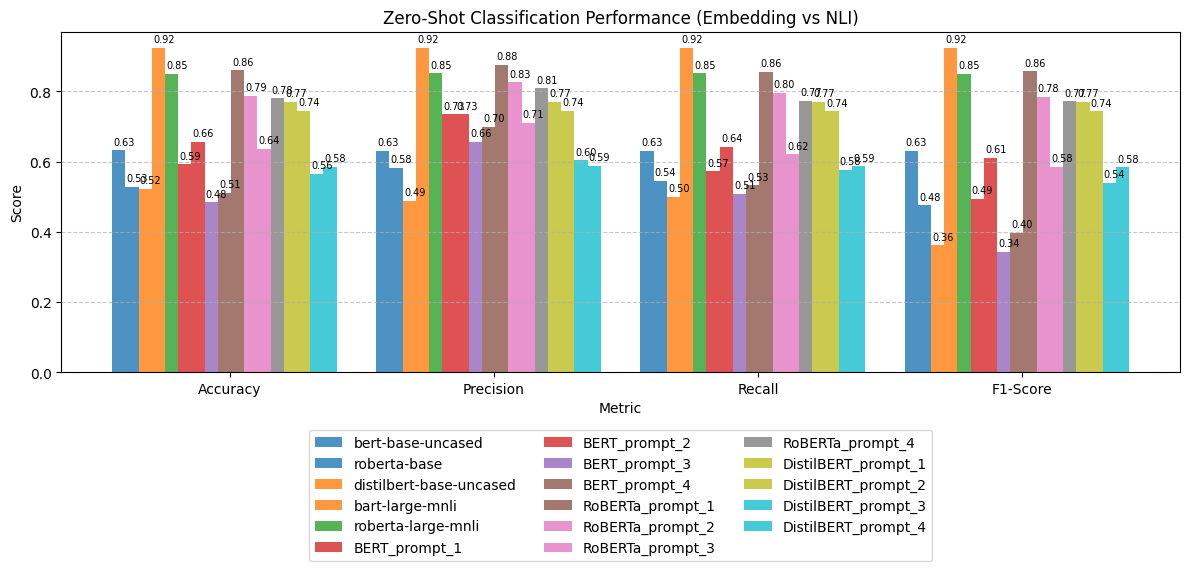


📊 Model Comparison (Accuracy):
bart-large-mnli: 0.9240
RoBERTa_prompt_1: 0.8600
roberta-large-mnli: 0.8500
RoBERTa_prompt_2: 0.7880
RoBERTa_prompt_4: 0.7800
DistilBERT_prompt_1: 0.7700
DistilBERT_prompt_2: 0.7440
BERT_prompt_2: 0.6560
RoBERTa_prompt_3: 0.6360
bert-base-uncased: 0.6320
BERT_prompt_1: 0.5920
DistilBERT_prompt_4: 0.5840
DistilBERT_prompt_3: 0.5640
roberta-base: 0.5280
distilbert-base-uncased: 0.5220
BERT_prompt_4: 0.5100
BERT_prompt_3: 0.4840


In [122]:
# Convert to DataFrame
df = pd.DataFrame(metrics_data)

# Reshape for grouped bar chart
metrics_df = pd.melt(df, 
                     id_vars=["Model"],
                     value_vars=["Accuracy", "Precision", "Recall", "F1-Score"],
                     var_name="Metric", value_name="Score")

# Set up the plot
plt.figure(figsize=(12, 6))
bar_width = 0.05
opacity = 0.8

# Create grouped bar chart
ax = plt.subplot(111)

# Get unique models and metrics
models = df["Model"].unique()
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Set x positions for bars
x_pos = np.arange(len(metrics))

# Plot bars for each model
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df["Model"] == model]
    
    # Make sure we have all metrics for this model
    values = []
    for metric in metrics:
        metric_row = model_data[model_data["Metric"] == metric]
        if len(metric_row) > 0:
            values.append(metric_row["Score"].values[0])
        else:
            values.append(0)  # Default if missing
    
    offset = bar_width * (i - len(models)/2 + 0.1)
    plt.bar(x_pos + offset, 
            values, 
            bar_width, 
            alpha=opacity,
            color=colors[i],
            label=model)

# Customize plot
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Zero-Shot Classification Performance (Embedding vs NLI)')
plt.xticks(x_pos, metrics)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add value labels on top of bars
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df["Model"] == model]
    offset = bar_width * (i - len(models)/2 + 0.5)
    
    values = []
    for metric in metrics:
        metric_row = model_data[model_data["Metric"] == metric]
        if len(metric_row) > 0:
            values.append(metric_row["Score"].values[0])
        else:
            values.append(0)
    
    for j, score in enumerate(values):
        plt.text(j + offset, score + 0.01, f'{score:.2f}', 
                 ha='center', va='bottom', fontsize=7)


plt.show()

# Print comparative summary
print("\n📊 Model Comparison (Accuracy):")
for model_name, result in sorted(combined_results.items(), key=lambda x: x[1]["report"]["accuracy"], reverse=True):
    acc = result["report"]["accuracy"]
    if "/" in model_name:
        model_short = model_name.split("/")[1]
    else:
        model_short = model_name
    print(f"{model_short}: {acc:.4f}")

### 🔍 Performance Summary

We explored **zero-shot classification via Cloze-style prompts**, applying several templated sentence structures to three models: **BERT**, **RoBERTa**, and **DistilBERT**.

---

#### 📈 Key Observations

1. **RoBERTa Performs Best in Zero-Shot**:
   - With the prompt `"{}. This movie was really {}."` and targets `["good", "bad"]`, **RoBERTa reached 86% F1**  approaching the performance of a supervised TF-IDF + Logistic Regression baseline (88%).
   - It also handled other prompts relatively well, with **3 prompts scoring above 70% F1**.

2. **DistilBERT Shows Competitive Results**:
   - Despite being lighter, **DistilBERT achieved >75% F1** on two prompts.
   - Its performance is generally consistent, and with tuning, it could be an efficient alternative for real-time or edge applications.

3. **BERT Underperforms in Cloze Format**:
   - Most prompts yielded **subpar results**, with some F1 scores **lower than a random baseline (50%)**.
   - This suggests **BERT’s MLM behavior is more sensitive** to how the prompt is structured, or its masked token inference is less calibrated for classification prompts.

4. **Template Matters — A Lot**:
   - Prompts like `"{}. Did you like the movie? {}."` failed across all models — showing **low recall** for negative sentiment and severely **imbalanced predictions**.
   - Templates that clearly align sentiment with polarity words (e.g., “good/bad” after “This movie was…”) yield much **better discriminative signals**.

---

#### 🧠 Why Does This Matter?

- **Cloze-style classification is promising**: With no labeled training data and basic prompt design, we approach classical supervised accuracy.
- It confirms the findings from [Schick & Schütze (2020)](https://arxiv.org/abs/2001.07676), who demonstrate that **pretrained masked language models can learn classification tasks from natural prompts**.

---

#### 💡 What’s Next?

- **Prompt Optimization**:
  - Try **more templates**, ensemble across them, or tune word choices (e.g., “great” vs. “excellent”).

- **Use as Weak Labels**:
  - These predictions could serve as **pseudo-labels** for weak supervision.
  - You can **train a downstream model** on a larger dataset labeled using Cloze tasks.

- **Explore Calibration**:
  - Some models are overconfident or biased toward one label.
  - Use temperature scaling or threshold tuning to improve decision boundaries.

## 🧪 Step 5: Weak Supervision via Zero-Shot Labeling

When we don’t have enough high-quality labeled data, **weak supervision** is a valuable alternative.  
Instead of relying on one perfect labeler, we **combine noisy labeling sources** to approximate ground truth.

In this notebook, we use:

### ⚙️ Strategy: Combine Weak Labels from Cloze Prompts

We’ve already seen that different **Cloze-style prompts** can yield meaningful (but not perfect) zero-shot predictions.  
Now we’ll treat each prompt as a **weak labeling function**, and **combine** their outputs to create a pseudo-labeled dataset.

> Our goal is to see whether a simple combination of weak signals can outperform individual prompts.

---

### 🧰 Related Tools: Snorkel (Optional)

[**Snorkel**](https://snorkel.org/) is a popular framework that:
- Models the **accuracy, bias, and correlation** of multiple weak labelers.
- Uses **generative models** to produce cleaner labels.
- Outputs **confidence-weighted training data** for downstream models.

In [ ]:
import numpy as np

# Assuming you have the results stored in a dictionary
models = {
    "RoBERTa_prompt_1": {"accuracy": combined_results["RoBERTa_prompt_1"].get('report').get('accuracy'), "probabilities": combined_results["RoBERTa_prompt_1"].get("probabilities")},
    "RoBERTa_prompt_2": {"accuracy": combined_results["RoBERTa_prompt_2"].get('report').get('accuracy'), "probabilities": combined_results["RoBERTa_prompt_2"].get("probabilities")},
    "RoBERTa_prompt_4": {"accuracy": combined_results["RoBERTa_prompt_4"].get('report').get('accuracy'), "probabilities": combined_results["RoBERTa_prompt_4"].get("probabilities")},
    "DistilBERT_prompt_1": {"accuracy": combined_results["DistilBERT_prompt_1"].get('report').get('accuracy'), "probabilities": combined_results["DistilBERT_prompt_1"].get("probabilities")},
    "DistilBERT_prompt_2": {"accuracy": combined_results["DistilBERT_prompt_2"].get('report').get('accuracy'), "probabilities": combined_results["DistilBERT_prompt_2"].get("probabilities")}
}

# 1. Simple average of predictions
all_probs = [models[key]["probabilities"] for key in models]
average_predictions = np.mean(all_probs, axis=0)
average_labels = 1 - np.argmax(average_predictions, axis=1)

# 2. Weighted average based on accuracy
weights = np.array([models[key]["accuracy"] for key in models])
weights = weights / np.sum(weights) 

weighted_predictions = np.zeros_like(models["RoBERTa_prompt_1"]["probabilities"])
for i, key in enumerate(models):
    weighted_predictions += models[key]["probabilities"] * weights[i]

weighted_labels = 1 - np.argmax(weighted_predictions, axis=1)

mean_predictions = {"average": {"report": classification_report(sample_labels, average_labels, target_names=labels, output_dict=True), "predictions": average_labels, "probabilities": average_predictions},
                    "weighted": {"report": classification_report(sample_labels, weighted_labels, target_names=labels, output_dict=True), "predictions": weighted_labels, "probabilities": weighted_predictions}}

# Compare results
print("Average predictions of :")
print(classification_report(sample_labels, average_labels, target_names=labels))

print("Weighted predictions:")
print(classification_report(sample_labels, weighted_labels, target_names=labels))

Average predictions of :
              precision    recall  f1-score   support

        good       0.88      0.87      0.87       238
         bad       0.88      0.89      0.89       262

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500

Weighted predictions:
              precision    recall  f1-score   support

        good       0.88      0.87      0.87       238
         bad       0.88      0.89      0.89       262

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



In [160]:
# Combine all results for comparison
combined_results = {key: value for key, value in cloze_task_results.items() if key in models}
combined_results.update(mean_predictions)

# Extract metrics for comparison
metrics_data = []

for model_name, result in combined_results.items():
        
    report = result["report"]
    
    # Get overall metrics
    accuracy = report["accuracy"]
    
    # Get averaged metrics (macro avg)
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]
    
    # Store in data list
    metrics_data.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": macro_precision,
        "Recall": macro_recall,
        "F1-Score": macro_f1
    })

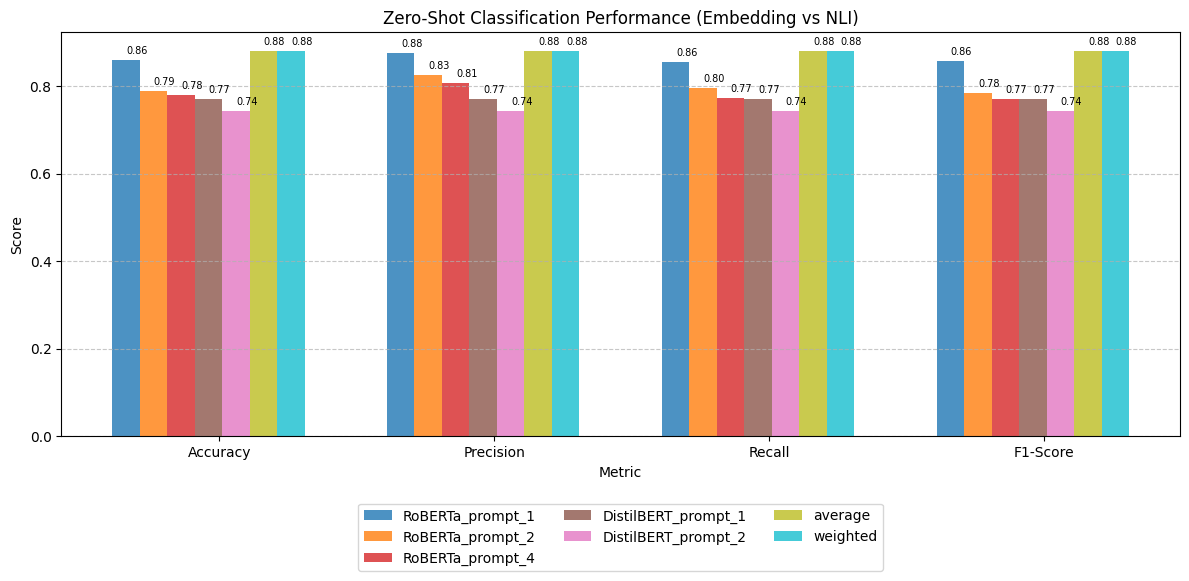


📊 Model Comparison (Accuracy):
average: 0.8800
weighted: 0.8800
RoBERTa_prompt_1: 0.8600
RoBERTa_prompt_2: 0.7880
RoBERTa_prompt_4: 0.7800
DistilBERT_prompt_1: 0.7700
DistilBERT_prompt_2: 0.7440


In [162]:
# Convert to DataFrame
df = pd.DataFrame(metrics_data)

# Reshape for grouped bar chart
metrics_df = pd.melt(df, 
                     id_vars=["Model"],
                     value_vars=["Accuracy", "Precision", "Recall", "F1-Score"],
                     var_name="Metric", value_name="Score")

# Set up the plot
plt.figure(figsize=(12, 6))
bar_width = 0.1
opacity = 0.8

# Create grouped bar chart
ax = plt.subplot(111)

# Get unique models and metrics
models = df["Model"].unique()
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Set x positions for bars
x_pos = np.arange(len(metrics))

# Plot bars for each model
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df["Model"] == model]
    
    # Make sure we have all metrics for this model
    values = []
    for metric in metrics:
        metric_row = model_data[model_data["Metric"] == metric]
        if len(metric_row) > 0:
            values.append(metric_row["Score"].values[0])
        else:
            values.append(0)  # Default if missing
    
    offset = bar_width * (i - len(models)/2 + 0.1)
    plt.bar(x_pos + offset, 
            values, 
            bar_width, 
            alpha=opacity,
            color=colors[i],
            label=model)

# Customize plot
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Zero-Shot Classification Performance (Embedding vs NLI)')
plt.xticks(x_pos, metrics)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add value labels on top of bars
for i, model in enumerate(models):
    model_data = metrics_df[metrics_df["Model"] == model]
    offset = bar_width * (i - len(models)/2 + 0.5)
    
    values = []
    for metric in metrics:
        metric_row = model_data[model_data["Metric"] == metric]
        if len(metric_row) > 0:
            values.append(metric_row["Score"].values[0])
        else:
            values.append(0)
    
    for j, score in enumerate(values):
        plt.text(j + offset, score + 0.01, f'{score:.2f}', 
                 ha='center', va='bottom', fontsize=7)


plt.show()

# Print comparative summary
print("\n📊 Model Comparison (Accuracy):")
for model_name, result in sorted(combined_results.items(), key=lambda x: x[1]["report"]["accuracy"], reverse=True):
    acc = result["report"]["accuracy"]
    if "/" in model_name:
        model_short = model_name.split("/")[1]
    else:
        model_short = model_name
    print(f"{model_short}: {acc:.4f}")

### ✅ Weak Supervision Can Boost Zero-Shot Learning

By combining predictions from our **top-performing Cloze-based zero-shot classifiers**, we were able to achieve:

#### 🔢 Final Performance (500 Test Reviews):
| Aggregation Method     | Accuracy | F1-Score |
|------------------------|----------|----------|
| **Averaged Predictions** | **88.0%** | **88.0%** |
| **Weighted Predictions** | **88.0%** | **88.0%** |

This clearly **outperforms each individual model/prompt**:
- Best single prompt (RoBERTa): **86.0%**
- DistilBERT and others: **74–78%**

---

#### 🤖 What Does This Mean?

Weak supervision — even with basic aggregation — can:
- **Amplify weak signals** from multiple imperfect classifiers.
- **Smooth out biases** introduced by any one template or model.
- Produce **pseudo-labels** that rival strong supervised models like TF-IDF + Logistic Regression (~88%).

---

#### 🧰 Next Steps

In practice, we could:
- Use these **combined predictions as training data** to fine-tune a lightweight classifier (e.g., TF-IDF + Logistic Regression or DistilBERT).
- Explore more advanced denoising tools like **Snorkel** to:
  - Model dependencies between prompts.
  - Estimate confidence per label.
  - Generate even more reliable weak labels.

This makes weak supervision a **powerful strategy** in low-label scenarios and a great stepping stone toward fully supervised fine-tuning

---

## 🧩 Step 6: Few-Shot Classification with SetFit

Now let’s explore **SetFit** — one of the most promising modern approaches for few-shot learning in NLP.

SetFit stands for **"Setence Transformer Fine-Tuning"** and was introduced by Tunstall et al. (2022).  
It leverages **contrastive learning** to achieve excellent performance even with **just 8–16 labeled examples** per class.

---

### 💡 How Does SetFit Work?

SetFit splits the classification task into two stages:

1. **Contrastive Learning (Representation Learning)**  
   Instead of training with class labels directly, the model learns which sentence pairs are:
   - **Semantically similar** (should be close in embedding space)
   - **Semantically different** (should be far apart)

   This step helps build a powerful embedding space using **only a few labeled examples**.

2. **Simple Classifier Head**  
   Once the embedding space is trained, a lightweight classifier (like Logistic Regression) is trained **on top of it**.

---

### 🎯 Why Contrastive Learning?

- Imagine giving the model **pairs of reviews**:
  - Both are "positive" → Pull them closer together
  - One "positive", one "negative" → Push them apart
- Over time, the model **naturally clusters similar examples**, even with very few labels.

This is similar to how humans **generalize concepts** after seeing just a few examples.

---

### 🛠️ What Makes SetFit Special?

- It **avoids prompt engineering** and **doesn’t need language modeling**.
- It works **without GPUs** — training runs in seconds even on CPU.
- With **as few as 8–16 examples per class**, it can rival large-scale fine-tuning.

---

### 🧪 What We’ll Do

To test SetFit, we run an experiment where we:

- Train the model on **increasing amounts of labeled data**:  
  `4, 8, 16, 32, 64, 128` labeled examples.
- For each sample size, we repeat training over **10 random seeds** to get stable estimates.
- Evaluate on a fixed **500-example test set**.

---

### 🧬 Code Logic (Simplified)

```python
sample_sizes = [4, 8, 16, 32, 64, 128]
num_iterations = 10

# For each sample size, repeat:
for size in sample_sizes:
    for iteration in range(num_iterations):
        - Sample a balanced train set with `size` examples
        - Fine-tune SetFit model (MiniLM)
        - Evaluate on the same test set
        - Store metrics: Accuracy, F1, Precision, Recall
```

In [172]:
import numpy as np
from setfit import SetFitModel, SetFitTrainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset

# Define sample sizes to experiment with
sample_sizes = [4, 8, 16, 32, 64, 128]
num_iterations = 10
metrics = ['accuracy', 'f1', 'precision', 'recall']
results = {size: {metric: [] for metric in metrics} for size in sample_sizes}

#dataset['train'] = dataset['train'].rename_column("labels", "label")
#dataset['test'] = dataset['test'].rename_column("labels", "label")

# Function to sample balanced dataset
def sample_balanced_dataset(dataset, num_samples, seed=None):
    # Get positive and negative examples
    pos_examples = dataset.filter(lambda x: x['label'] == 1)
    neg_examples = dataset.filter(lambda x: x['label'] == 0)
    
    # Sample equal numbers from each class
    samples_per_class = num_samples // 2
    
    if seed is not None:
        pos_sampled = pos_examples.shuffle(seed=seed).select(range(samples_per_class))
        neg_sampled = neg_examples.shuffle(seed=seed).select(range(samples_per_class))
    else:
        pos_sampled = pos_examples.shuffle().select(range(samples_per_class))
        neg_sampled = neg_examples.shuffle().select(range(samples_per_class))
    
    # Combine and shuffle
    combined = Dataset.from_dict({
        'text': pos_sampled['text'] + neg_sampled['text'],
        'label': pos_sampled['label'] + neg_sampled['label']
    })
    
    return combined.shuffle(seed=seed) if seed is not None else combined.shuffle()

# Prepare test set (use a fixed portion of the dataset)
test_set = dataset['test'].select(random_indices)

# Run experiments
for size in sample_sizes:
    print(f"Training with {size} examples...")
    
    for iteration in range(num_iterations):
        print(f"  Iteration {iteration+1}/{num_iterations}")
        
        # Sample balanced training data
        train_samples = sample_balanced_dataset(dataset['train'], size, seed=42+iteration)
        model = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

        # Initialize and train SetFit model
        trainer = SetFitTrainer(
            model=model,
            train_dataset=train_samples,
            eval_dataset=test_set,
            batch_size=16,
            num_iterations=20,
            num_epochs=1
        )
        
        trainer.train()
        
        # Evaluate
        predictions = trainer.model.predict(test_set['text'])
        
        # Calculate metrics
        results[size]['accuracy'].append(accuracy_score(test_set['label'], predictions))
        results[size]['f1'].append(f1_score(test_set['label'], predictions))
        results[size]['precision'].append(precision_score(test_set['label'], predictions))
        results[size]['recall'].append(recall_score(test_set['label'], predictions))

Training with 4 examples...
  Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.165400


  Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.211100


  Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.168700


  Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.260500


  Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.199800


  Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.111200


  Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.218800


  Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.162400


  Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.143500


  Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 160
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.246600


Training with 8 examples...
  Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.201600


  Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.345300


  Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.209800


  Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.351100


  Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.282800


  Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.263900


  Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.282200


  Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.354000


  Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.302000


  Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 320
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.271100


Training with 16 examples...
  Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.252200


  Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.236700


  Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.276600


  Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.207200


  Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.277400


  Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.316600


  Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.241000


  Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.274200


  Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.288200


  Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 640
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.198500


Training with 32 examples...
  Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.423000
50,0.206100


  Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.246500
50,0.194700


  Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.301700
50,0.226400


  Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.199700
50,0.192200


  Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.327900
50,0.202000


  Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.343900
50,0.227100


  Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.266300
50,0.225700


  Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.269800
50,0.232400


  Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.318400
50,0.225900


  Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.301700
50,0.226700


Training with 64 examples...
  Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.374200
50,0.260500
100,0.210700
150,0.087600


  Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.425400
50,0.239600
100,0.096900
150,0.010700


  Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.436400
50,0.248300
100,0.173300
150,0.030800


  Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.377000
50,0.239600
100,0.073800
150,0.009400


  Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.312900
50,0.247100
100,0.169500
150,0.041300


  Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.436800
50,0.248800
100,0.143400
150,0.023100


  Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.413100
50,0.253200
100,0.168500
150,0.039300


  Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.353900
50,0.248300
100,0.170500
150,0.033400


  Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.396400
50,0.242400
100,0.142800
150,0.023300


  Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 2560
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.368900
50,0.254600
100,0.129800
150,0.014700


Training with 128 examples...
  Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 5120
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.396300
50,0.256800
100,0.244900
150,0.164400
200,0.044000
250,0.011100
300,0.006500


  Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 5120
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.365600
50,0.256600
100,0.206800
150,0.056300
200,0.008200
250,0.003100
300,0.002300


  Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 5120
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.374600
50,0.253500
100,0.233000
150,0.088900
200,0.015900
250,0.005400
300,0.004200


  Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 5120
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.351200
50,0.243900
100,0.155900
150,0.024600
200,0.003500
250,0.001800
300,0.001500


  Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 5120
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.337000
50,0.258500
100,0.240300
150,0.145600
200,0.042000
250,0.008700
300,0.004600


  Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 5120
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.339100
50,0.262900
100,0.223900
150,0.085200
200,0.016400
250,0.005400
300,0.004400


  Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 5120
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.347300
50,0.253000
100,0.212200
150,0.058000
200,0.009500
250,0.003200
300,0.002300


  Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 5120
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.370400
50,0.261600
100,0.238000
150,0.107600
200,0.025300
250,0.006800
300,0.004200


  Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 5120
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.324800
50,0.261000
100,0.206400
150,0.046600
200,0.005400
250,0.002600
300,0.001700


  Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_33895/2856560924.py:56: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 5120
  Batch size = 16
  Num epochs = 1
/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,0.288600
50,0.252500
100,0.241200
150,0.112000
200,0.024600
250,0.007100
300,0.004100


### 📈 Learning Curves: How Much Data Do We Really Need?

Now that we've trained SetFit across various dataset sizes, let’s **visualize the performance gains** as we increase the number of labeled training examples.

#### 📊 What This Tells Us

For each curve:
- The **line** shows the **average score** over 10 training runs.
- The **shaded region** shows the **standard deviation** (variation across random seeds).

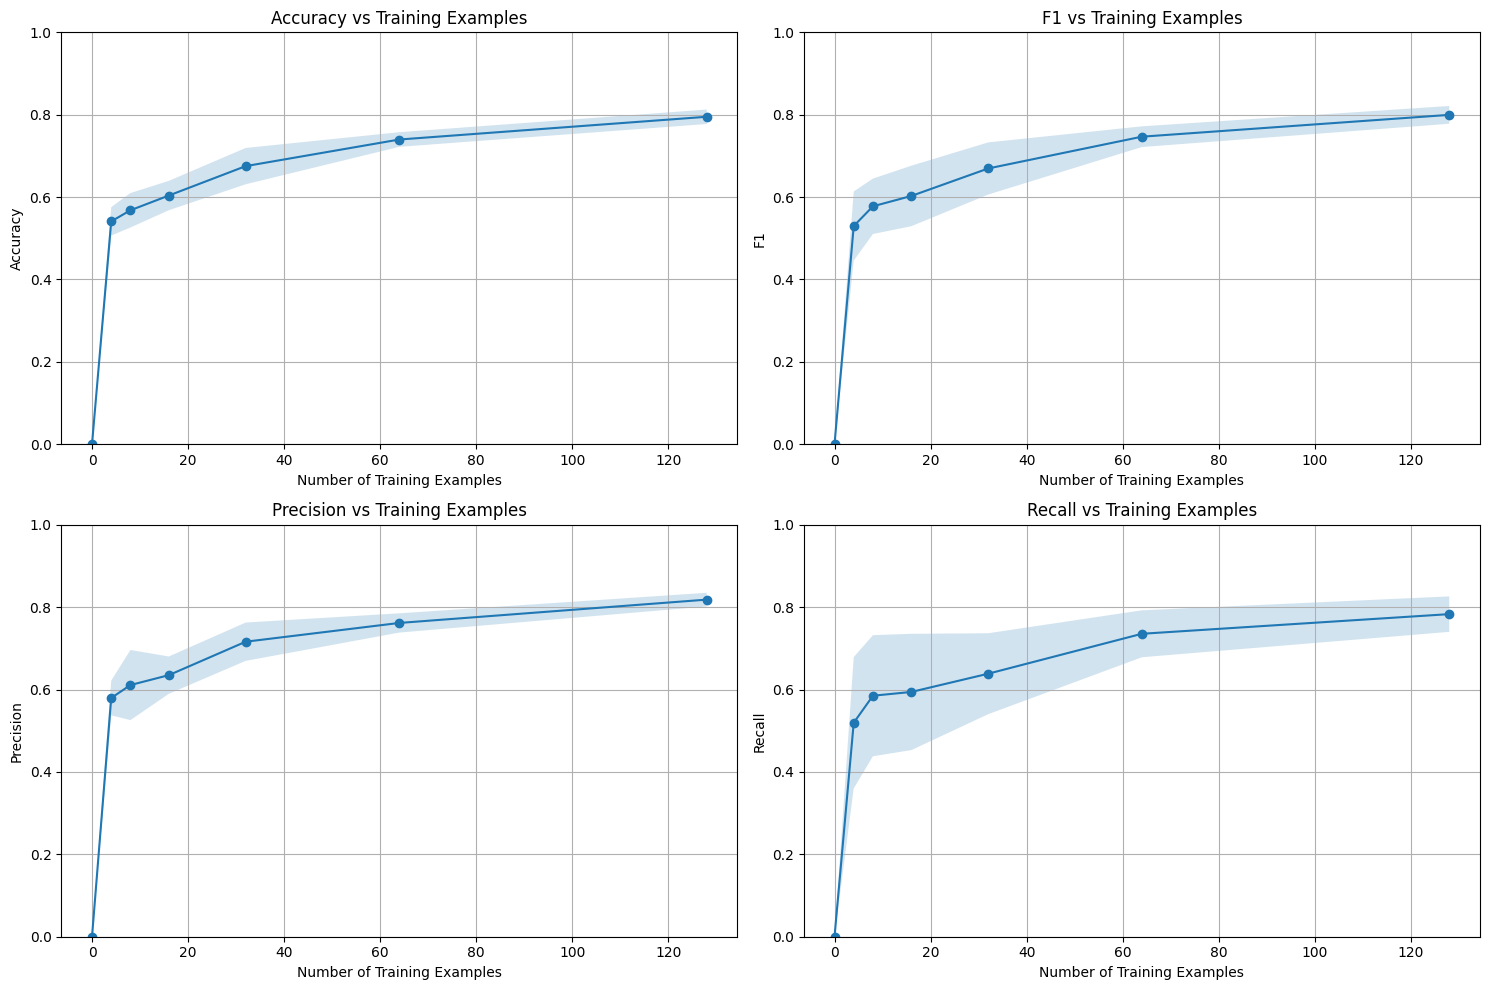

In [176]:
# Calculate mean and std for each metric and sample size
summary = {metric: {'mean': [0], 'std': [0]} for metric in metrics}
for metric in metrics:
    for size in sample_sizes:
        summary[metric]['mean'].append(np.mean(results[size][metric]))
        summary[metric]['std'].append(np.std(results[size][metric]))

# Plot learning curves
# Plot learning curves
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    means = summary[metric]['mean']
    stds = summary[metric]['std']
    
    # Plot the mean line
    plt.plot([0] + sample_sizes, means, 'o-', label=metric.capitalize())
    
    # Fill between for standard deviation
    plt.fill_between(
        [0] + sample_sizes,
        [max(0, m - s) for m, s in zip(means, stds)],  # Ensure lower bound doesn't go below 0
        [min(1, m + s) for m, s in zip(means, stds)],  # Ensure upper bound doesn't exceed 1
        alpha=0.2
    )
    
    plt.title(f'{metric.capitalize()} vs Training Examples')
    plt.xlabel('Number of Training Examples')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    plt.ylim(0, 1)  # Set y-axis to start at 0 and end at 1
    
plt.tight_layout()
plt.savefig('setfit_learning_curves.png')
plt.show()

### ✅ Final Thoughts: SetFit vs Zero-Shot Learning

#### 🚀 SetFit: A Few Labels, Big Impact

With only a **few dozen labeled examples**, SetFit manages to:
- **Outperform zero-shot learning** methods like BERT/DistilBERT cloze tasks and latent similarity.
- Match or **approach the 88% accuracy** obtained via tf-idf + Logistic Regression baseline (but with 25k data).

| # Labels | Accuracy | F1     | Precision | Recall | Std (Accuracy) |
|----------|----------|--------|-----------|--------|----------------|
| 4        | 0.54     | 0.53   | 0.58      | 0.52   | 0.03           |
| 8        | 0.57     | 0.58   | 0.61      | 0.59   | 0.04           |
| 32       | 0.68     | 0.67   | 0.72      | 0.64   | 0.04           |
| 128      | **0.80** | **0.80** | **0.82** | **0.78** | **0.02**     |

#### 📊 What Makes SetFit Special?

1. **Robust Learning Curve**  
   - Even with **4–8 samples**, SetFit starts learning coherent patterns.
   - The **variance (standard deviation)** across random seeds **shrinks as we scale up**, showing **stability** and **robustness**.

2. **Contrastive Pretraining FTW**  
   - SetFit uses a contrastive learning phase to **pull similar examples closer** and **push dissimilar ones apart** in embedding space.
   - This lets the model learn **rich semantic clusters**, even from tiny datasets.

3. **Fine-tuning Simplicity**  
   - Unlike traditional fine-tuning, SetFit doesn't require gradients through a large Transformer model — making it **extremely fast** and **lightweight**.
